# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Initial Model Evaluation")
mlflow.set_tag("mlflow.runName", "EfficientNet_UnFreeze_All")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_Efficent_Net')

2025/06/19 14:57:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [7]:
print(len(data))

178


In [8]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [9]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [10]:
# Stratified K Folde Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to Load Pre-trained Model from Pytorch

In [11]:
def create_model():
    # Load EfficientNet-B3 with pretrained weights
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_classes = 4

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the last layer (classifier[1]) to match num_classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Unfreeze just the new classifier layer
    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

# Grid Search Parameters

In [12]:
# Grid Search Parameters
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'train_batch_size': [16, 32, 64],
    'test_batch_size': [16],
    'weight_decay': [0.0, 1e-4],
}

In [13]:
# Use itertools.product to iterate through combinations
from itertools import product

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Model training

In [18]:
from torch.utils.checkpoint import checkpoint
# Wrap a block with checkpointing
def checkpointed_block(block, x):
    def custom_forward(*inputs):
        return block(*inputs)
    return checkpoint(custom_forward, x)

# Create a new forward with checkpointing on each block
class EfficientNetCheckpointed(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.stem = model.features[0]  # usually stem conv
        self.blocks = nn.ModuleList(model.features[1:])  # MBConv blocks
        self.avgpool = model.avgpool
        self.classifier = model.classifier

    def forward(self, x):
        x = self.stem(x)
        for block in self.blocks:
            x = checkpointed_block(block, x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
def train(model, optimizer, dataloader, criterion, device):
    model.train()
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [20]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [21]:
categories = []
accuracies = []
results = []
num_epochs = 40
for params in param_combinations:
    config = dict(zip(param_names, params))
    print(f"Testing params: {config}")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"Fold {fold+1}")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=config['train_batch_size'], shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=config['test_batch_size'])

        model = create_model()  # Initialize fresh model per fold
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        criterion = torch.nn.CrossEntropyLoss()
        #model.to(DEVICE)
        model = EfficientNetCheckpointed(model).to(DEVICE)

        # Train and evaluate
        for epoch in range(num_epochs):  # or another stopping criterion
            train(model, optimizer, train_loader, criterion, DEVICE)

        acc = evaluate(model, val_loader, DEVICE)
        fold_accuracies.append(acc)

    avg_acc = np.mean(fold_accuracies)
    print(f"Average Accuracy: {avg_acc:.4f}")
    results.append((config, avg_acc))
    categories.append(str(config).replace("'", ""))
    accuracies.append(avg_acc)

Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.5449
Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.5233
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.6016
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.5167
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.5338
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.5730
Testing params: {'lr': 0.001, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8646
Testing params: {'lr': 0.001, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8262
Testing params: {'lr': 0.001, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8763
Testing params: {'lr': 0.001, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8484
Testing params: {'lr': 0.001, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8260
Testing params: {'lr': 0.001, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.8317
Testing params: {'lr': 0.0001, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9495
Testing params: {'lr': 0.0001, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9551
Testing params: {'lr': 0.0001, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9211
Testing params: {'lr': 0.0001, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9157
Testing params: {'lr': 0.0001, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9270
Testing params: {'lr': 0.0001, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1


C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.9046


# Visualize

C:\Users\Phuong Hoang Dinh\AppData\Local\Temp\ipykernel_15520\345311558.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


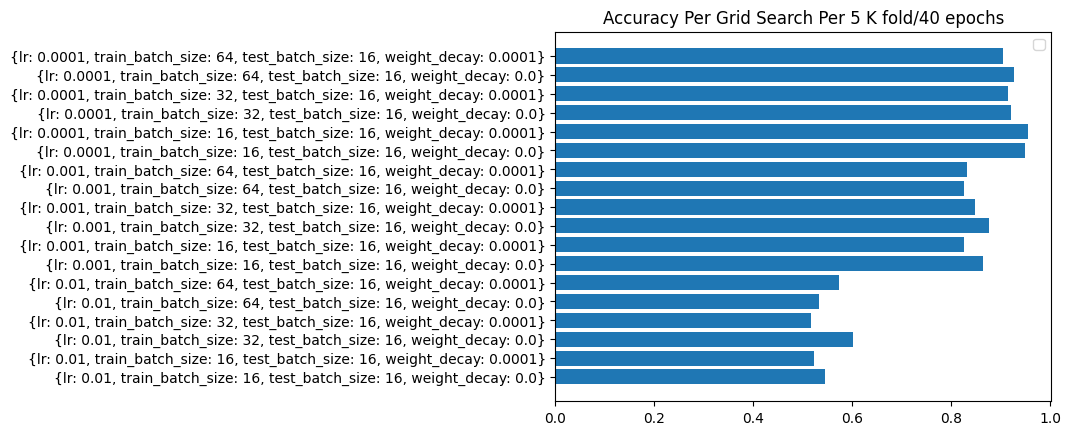

In [22]:
plt.barh(categories, accuracies)
plt.legend()
plt.title("Accuracy Per Grid Search Per 5 K fold/40 epochs")
plt.show()

# Model Evaluation Logging

In [23]:
# Log result
for category, accuracy in zip(categories, accuracies):
    mlflow.log_metric(category.replace("'", "").replace("{","").replace("}","").replace(": ", "").replace(", ", " "), accuracy)